### Look at the relationship between Inflation, mortgage lock rates, and the Federal Reserve Prime Rate

In [12]:
import requests

## Read in webpage that contains mortgage rates data

In [13]:
url = "http://www.freddiemac.com/pmms/pmms30.html"
data = requests.get(url)

with open("lockrates.html", "w+", encoding="utf-8") as f:
    f.write(data.text)

In [14]:
from bs4 import BeautifulSoup

In [15]:
with open("lockrates.html", encoding="utf-8") as f:
    page = f.read()

In [16]:
soup = BeautifulSoup(page, "html.parser")

In [17]:
mort_rate_tables = soup.findAll('table', class_="hover")

In [18]:
import pandas as pd

mort_rate_table = pd.read_html(str(mort_rate_tables))

In [19]:
all_tables = pd.DataFrame


### Combine the charts to one Mortgage Rate dataset

The tables contained a lot of columns I wanted to delete so I merged them individually instead of concating them all at once

In [20]:
mort_rate_table0 = mort_rate_table[0]

In [21]:
morts = mort_rate_table0.merge(mort_rate_table[1])
morts = morts.merge(mort_rate_table[2])
morts = morts.merge(mort_rate_table[3])
morts = morts.merge(mort_rate_table[4])
morts = morts.merge(mort_rate_table[5])
morts = morts.merge(mort_rate_table[6])
morts = morts.merge(mort_rate_table[7])
morts = morts.merge(mort_rate_table[8])
morts = morts.merge(mort_rate_table[9])
morts = morts.merge(mort_rate_table[10])



In [22]:
morts.head()

,Unnamed: 0,2022,2022.1,2021,2021.1,2020,2020.1,2019,2019.1,2018,...,1975,1975.1,1974,1974.1,1973,1973.1,1972,1972.1,1971,1971.1
0,NaN,Rate,Pts,Rate,Pts,Rate,Pts,Rate,Pts,Rate,...,Rate,Pts,Rate,Pts,Rate,Pts,Rate,Pts,Rate,Pts
1,January,3.45,0.7,2.74,0.7,3.62,0.7,4.46,0.5,4.03,...,9.43,1.2,8.54,1.0,7.44,0.9,7.44,1.0,na,na
2,February,NaN,NaN,2.81,0.7,3.47,0.7,4.37,0.5,4.33,...,9.10,1.2,8.46,1.0,7.44,1.0,7.32,0.9,na,na
3,March,NaN,NaN,3.08,0.7,3.45,0.7,4.27,0.5,4.44,...,8.89,1.1,8.41,1.0,7.46,0.9,7.29,0.9,na,na
4,April,NaN,NaN,3.06,0.7,3.31,0.7,4.14,0.5,4.47,...,8.82,1.0,8.58,1.0,7.54,0.9,7.29,0.9,7.31,na


### Clean up the Mortgage Rate dataset

I only wanted to keep the columns that contained the actual mortgage rate, so I deleted the columns that listed the change in rate points

In [23]:
dec_year = []
good_years = []
for column in morts.columns:
    try:
        int(column)
        good_years.append(str(column))
    except:
        dec_year.append(column)
        
dec_year = dec_year[1:]
good_years = good_years[1:-1]

In [24]:
morts = morts.drop(dec_year, axis=1)
morts = morts.drop([0, 13], axis=0)
morts = morts.drop(['2022', '1971'], axis=1)
morts = morts.rename({"Unnamed: 0": "month"}, axis=1)

In [25]:
morts.head()

,month,2021,2020,2019,2018,2017,2016,2015,2014,2013,...,1981,1980,1979,1978,1977,1976,1975,1974,1973,1972
1,January,2.74,3.62,4.46,4.03,4.15,3.87,3.67,4.43,3.41,...,14.90,12.88,10.39,9.01,8.72,9.02,9.43,8.54,7.44,7.44
2,February,2.81,3.47,4.37,4.33,4.17,3.66,3.71,4.30,3.53,...,15.13,13.04,10.41,9.14,8.67,8.81,9.10,8.46,7.44,7.32
3,March,3.08,3.45,4.27,4.44,4.2,3.69,3.77,4.34,3.57,...,15.40,15.28,10.43,9.20,8.69,8.76,8.89,8.41,7.46,7.29
4,April,3.06,3.31,4.14,4.47,4.05,3.61,3.67,4.34,3.45,...,15.58,16.32,10.50,9.35,8.75,8.73,8.82,8.58,7.54,7.29
5,May,2.96,3.23,4.07,4.59,4.01,3.60,3.84,4.19,3.54,...,16.40,14.26,10.69,9.57,8.83,8.76,8.91,8.97,7.65,7.37


### Melt the Mortgage Rate dataset

Having the year/month/values all on the same row will make it easier to analyze

In [26]:
morts_long = pd.melt(morts, id_vars=['month'], value_vars=[year for year in good_years])


In [27]:
morts_long['date'] = morts_long['month'] + ' ' + morts_long['variable']

In [28]:
#change the date to a pandas datetime datatype
morts_long['date'] = pd.to_datetime(morts_long['date'])

In [29]:
morts_long['value'] = morts_long['value'].astype(float)

In [30]:
morts_long = morts_long.sort_values('date')

### Create Pivot Table for Mortgage Rates and Visualize 

In [31]:
mort_rate_piv = morts_long.pivot_table(index='date', values='value')

In [32]:
mort_rate_piv.head()

,value
date,
1972-01-01,7.44
1972-02-01,7.32
1972-03-01,7.29
1972-04-01,7.29
1972-05-01,7.37


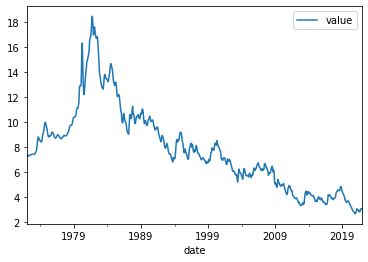

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

mort_rate_piv.plot(kind='line')
plt.show()

## Read in the Fed Prime Interest Rate from website

In [34]:
fed_url = "https://www.jpmorganchase.com/about/our-business/historical-prime-rate"
data = requests.get(fed_url)

with open("fedrates.html", "w+", encoding="utf-8") as f:
    f.write(data.text)

In [35]:
with open("fedrates.html", encoding="utf-8") as fed_f:
    page = fed_f.read()

In [36]:
soup = BeautifulSoup(page, "html.parser")

In [37]:
fed_rate_tables = soup.find(class_="col-12 col-12-narrow")

In [38]:
fed_rate_tables = pd.read_html(str(fed_rate_tables))

In [39]:
feds = pd.concat(fed_rate_tables, ignore_index=True)

In [40]:
feds.head()

,Effective Date,Rate
0,3/16/2020,3.25%
1,3/4/2020,4.25%
2,10/31/2019,4.75%
3,9/19/2019,5.00%
4,8/1/2019,5.25%


### Clean up the Fed Rate dataset

In [41]:
#convert dates to pandas datetime datatype
feds["Effective Date"] = pd.to_datetime(feds["Effective Date"])
feds["Rate"] = feds["Rate"].str[:-1].astype(float)

In [42]:
pd.set_option('max_rows', 100)
feds.head()

,Effective Date,Rate
0,2020-03-16,3.25
1,2020-03-04,4.25
2,2019-10-31,4.75
3,2019-09-19,5.00
4,2019-08-01,5.25


### Create Pivot table for Fed Rate and Visualize

In [43]:
fed_piv = feds.pivot_table(index="Effective Date", values="Rate")

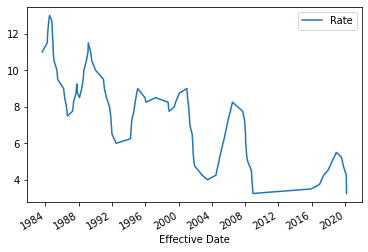

In [44]:
fed_piv.plot(kind='line')
plt.show()

## Read in Inflation Data from website

In [45]:
url = "https://www.usinflationcalculator.com/inflation/historical-inflation-rates/"
data = requests.get(url)

with open("inflation.html", "w+", encoding="utf-8") as f:
    f.write(data.text)

In [46]:
with open("inflation.html", encoding="utf-8") as f:
    page = f.read()

In [47]:
soup = BeautifulSoup(page, "html.parser")
inflation_table = soup.find('table')

### Create Inflation DataFrame

In [48]:
import pandas as pd

inflate_table = pd.read_html(str(inflation_table))[0]

In [49]:
inflate_table = inflate_table.drop(108, axis=0)
inflate_72 = inflate_table.iloc[58:,:]

In [50]:
inflate_72.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Ave
58,1972,3.3,3.5,3.5,3.5,3.2,2.7,2.9,2.9,3.2,3.4,3.7,3.4,3.2
59,1973,3.6,3.9,4.6,5.1,5.5,6.0,5.7,7.4,7.4,7.8,8.3,8.7,6.2
60,1974,9.4,10.0,10.4,10.1,10.7,10.9,11.5,10.9,11.9,12.1,12.2,12.3,11.0
61,1975,11.8,11.2,10.3,10.2,9.5,9.4,9.7,8.6,7.9,7.4,7.4,6.9,9.1
62,1976,6.7,6.3,6.1,6.0,6.2,6.0,5.4,5.7,5.5,5.5,4.9,4.9,5.8


### Clean up Inflation DataFrame

In [51]:
inflation = inflate_72.swapaxes('index', 'columns')

In [52]:
inflation.head()

,58,59,60,61,62,63,64,65,66,67,...,98,99,100,101,102,103,104,105,106,107
Year,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Jan,3.3,3.6,9.4,11.8,6.7,5.2,6.8,9.3,13.9,11.8,...,2.9,1.6,1.6,-0.1,1.4,2.5,2.1,1.6,2.5,1.4
Feb,3.5,3.9,10.0,11.2,6.3,5.9,6.4,9.9,14.2,11.4,...,2.9,2.0,1.1,0.0,1.0,2.7,2.2,1.5,2.3,1.7
Mar,3.5,4.6,10.4,10.3,6.1,6.4,6.6,10.1,14.8,10.5,...,2.7,1.5,1.5,-0.1,0.9,2.4,2.4,1.9,1.5,2.6
Apr,3.5,5.1,10.1,10.2,6.0,7.0,6.5,10.5,14.7,10.0,...,2.3,1.1,2.0,-0.2,1.1,2.2,2.5,2.0,0.3,4.2


In [53]:
years = list(range(1972, 2022))
inflation = inflation.set_axis(years, axis=1, inplace=False)
inflation = inflation.drop(['Year', 'Ave'])

In [54]:
inflation.head()

,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Jan,3.3,3.6,9.4,11.8,6.7,5.2,6.8,9.3,13.9,11.8,...,2.9,1.6,1.6,-0.1,1.4,2.5,2.1,1.6,2.5,1.4
Feb,3.5,3.9,10.0,11.2,6.3,5.9,6.4,9.9,14.2,11.4,...,2.9,2.0,1.1,0.0,1.0,2.7,2.2,1.5,2.3,1.7
Mar,3.5,4.6,10.4,10.3,6.1,6.4,6.6,10.1,14.8,10.5,...,2.7,1.5,1.5,-0.1,0.9,2.4,2.4,1.9,1.5,2.6
Apr,3.5,5.1,10.1,10.2,6.0,7.0,6.5,10.5,14.7,10.0,...,2.3,1.1,2.0,-0.2,1.1,2.2,2.5,2.0,0.3,4.2
May,3.2,5.5,10.7,9.5,6.2,6.7,7.0,10.9,14.4,9.8,...,1.7,1.4,2.1,0.0,1.0,1.9,2.8,1.8,0.1,5.0


In [55]:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
inflation["month"] = months

In [56]:
#like the other two sets of data, melting the dataframe makes it possible to create a pivot table
inflation_df = pd.melt(inflation, id_vars='month', value_vars=[year for year in years])

In [57]:
inflation_df

,month,variable,value
0,January,1972,3.3
1,February,1972,3.5
2,March,1972,3.5
3,April,1972,3.5
4,May,1972,3.2
...,...,...,...
595,August,2021,5.3
596,September,2021,5.4
597,October,2021,6.2
598,November,2021,6.8


In [58]:
inflation_df["variable"] = inflation_df["variable"].astype(str)
inflation_df["date"] = inflation_df["month"] + ' ' + inflation_df["variable"]
inflation_df["date"] = pd.to_datetime(inflation_df["date"])

In [59]:
inflation_df['value'] = inflation_df["value"].astype(float)

In [60]:
inflation_df

,month,variable,value,date
0,January,1972,3.3,1972-01-01
1,February,1972,3.5,1972-02-01
2,March,1972,3.5,1972-03-01
3,April,1972,3.5,1972-04-01
4,May,1972,3.2,1972-05-01
...,...,...,...,...
595,August,2021,5.3,2021-08-01
596,September,2021,5.4,2021-09-01
597,October,2021,6.2,2021-10-01
598,November,2021,6.8,2021-11-01


### Create Pivot Table for Inflation and Visualize

In [61]:
inflation_pivot = inflation_df.pivot_table(index='date', values='value')

In [62]:
inflation_pivot.head()

,value
date,
1972-01-01,3.3
1972-02-01,3.5
1972-03-01,3.5
1972-04-01,3.5
1972-05-01,3.2


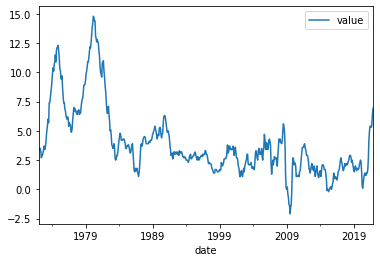

In [63]:
inflation_pivot.plot(kind='line')
plt.show()

## Combine graphs to see relationship

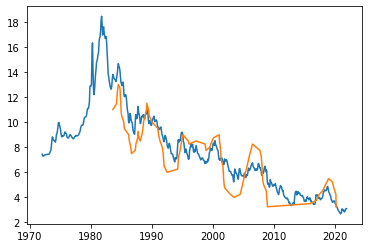

In [64]:
plt.plot(mort_rate_piv, label="Mortgage Rates")
plt.plot(fed_piv, label="Federal Prime Rates")
plt.show()

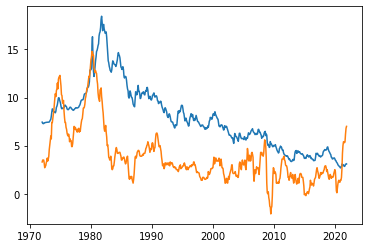

In [65]:
plt.plot(mort_rate_piv, label="Mortgage Rates")
plt.plot(inflation_pivot, label="Inflation Rate")
plt.show()

In [66]:
fed_crisis_2008 = (feds["Effective Date"] > "2007-01-01") & (feds["Effective Date"] < "2013-01-01")
mort_crisis_2008 = (morts_long["date"] > "2007-01-01") & (morts_long["date"] > "2010-01-01")

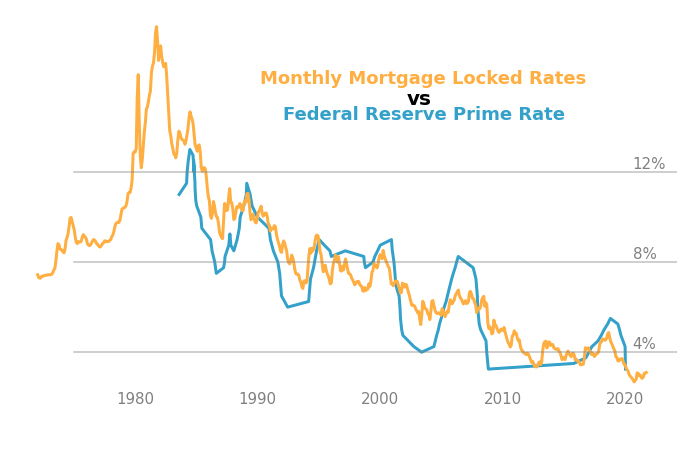

In [67]:
fig, ax1= plt.subplots(figsize=(12, 8))

for location in ['right', 'top', 'left', 'bottom']:
    ax1.spines[location].set_visible(False)

ax1.plot(feds["Effective Date"], feds["Rate"], linewidth=3, label = "Federal Reserve Prime Rate", color= "#33A1C9")
ax1.plot(morts_long["date"], morts_long["value"], linewidth=3, label = "Mortgage Locked Rates", color='#ffae42')

ax1.text(8080, 14.3, "Federal Reserve Prime Rate", size=18, color= "#33A1C9", weight='bold')
ax1.text(11780, 15, "vs", size=20, color= "black", weight='bold')
ax1.text(7400, 15.9, "Monthly Mortgage Locked Rates", size=18, color= "#ffae42", weight='bold')
ax1.axhline(y=4, xmin=0.1, xmax=1, c='grey', alpha=0.5)
ax1.axhline(y=8, xmin=0.1, xmax=1, c='grey', alpha=0.5)
ax1.axhline(y=12, xmin=0.1, xmax=1, c='grey', alpha=0.5)
ax1.text(y=4.15, x=18550, s="4%", size=15, c='grey')
ax1.text(y=8.15, x=18550, s="8%", size=15, c='grey')
ax1.text(y=12.15, x=18550, s="12%", size=15, c='grey')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.tick_params(bottom=False, left=False)
ax1.text(y=1.7, x=3100, s="1980", size=15, c='grey')
ax1.text(y=1.7, x=6750, s="1990", size=15, c='grey')
ax1.text(y=1.7, x=10400, s="2000", size=15, c='grey')
ax1.text(y=1.7, x=14100, s="2010", size=15, c='grey')
ax1.text(y=1.7, x=17750, s="2020", size=15, c='grey')
ax1.axhline(y=0.9, xmin=0.1, xmax=1, c='white', alpha=0.5)
plt.savefig('fed_vs_mortgage_rates.png')
plt.show()

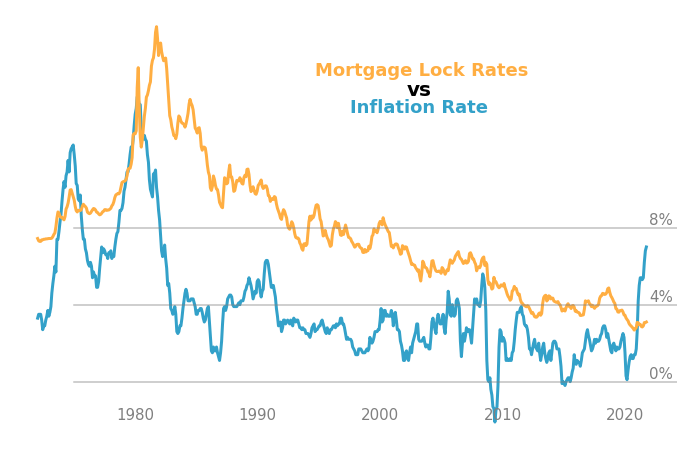

In [68]:
fig, ax1= plt.subplots(figsize=(12, 8))

for location in ['right', 'top', 'left', 'bottom']:
    ax1.spines[location].set_visible(False)

ax1.plot(inflation_df["date"], inflation_df["value"], linewidth=3, label = "Inflation Rate", color= "#33A1C9")
ax1.plot(morts_long["date"], morts_long["value"], linewidth=3, label = "Mortgage Locked Rates", color='#ffae42')

ax1.text(10080, 14, "Inflation Rate", size=18, color= "#33A1C9", weight='bold')
ax1.text(11780, 14.85, "vs", size=20, color= "black", weight='bold')
ax1.text(9050, 15.9, "Mortgage Lock Rates", size=18, color= "#ffae42", weight='bold')
ax1.axhline(y=4, xmin=0.1, xmax=1, c='grey', alpha=0.5)
ax1.axhline(y=8, xmin=0.1, xmax=1, c='grey', alpha=0.5)
ax1.axhline(y=0, xmin=0.1, xmax=1, c='grey', alpha=0.5)
ax1.text(y=4.15, x=19050, s="4%", size=15, c='grey')
ax1.text(y=8.15, x=19050, s="8%", size=15, c='grey')
ax1.text(y=0.15, x=19050, s="0%", size=15, c='grey')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.tick_params(bottom=False, left=False)
ax1.text(y=-2, x=3100, s="1980", size=15, c='grey')
ax1.text(y=-2, x=6750, s="1990", size=15, c='grey')
ax1.text(y=-2, x=10400, s="2000", size=15, c='grey')
ax1.text(y=-2, x=14100, s="2010", size=15, c='grey')
ax1.text(y=-2, x=17750, s="2020", size=15, c='grey')

plt.savefig('interest_vs_mortgage_rates.png')
plt.show()

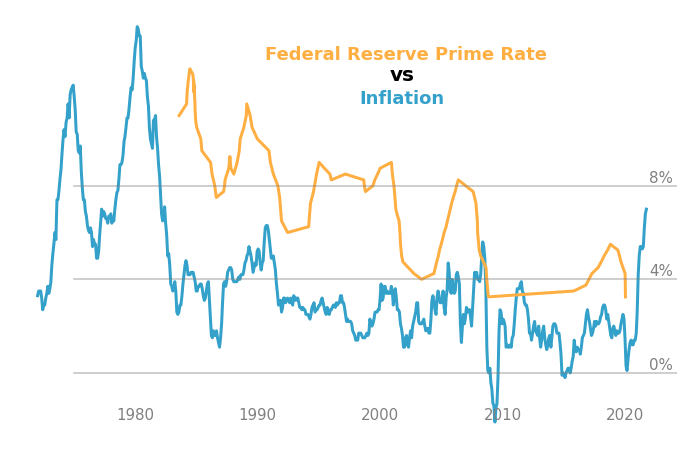

In [69]:
fig, ax1= plt.subplots(figsize=(12, 8))

for location in ['right', 'top', 'left', 'bottom']:
    ax1.spines[location].set_visible(False)

ax1.plot(inflation_df["date"], inflation_df["value"], linewidth=3, label = "Inflation", color= "#33A1C9")
ax1.plot(feds["Effective Date"], feds["Rate"], linewidth=3, label = "Federal Reserve Prime Rate", color= "#ffae42")

ax1.text(10380, 11.5, "Inflation", size=18, color= "#33A1C9", weight='bold')
ax1.text(11280, 12.5, "vs", size=20, color= "black", weight='bold')
ax1.text(7550, 13.4, "Federal Reserve Prime Rate", size=18, color= "#ffae42", weight='bold')
ax1.axhline(y=4, xmin=0.1, xmax=1, c='grey', alpha=0.5)
ax1.axhline(y=8, xmin=0.1, xmax=1, c='grey', alpha=0.5)
ax1.axhline(y=0, xmin=0.1, xmax=1, c='grey', alpha=0.5)
ax1.text(y=4.15, x=19050, s="4%", size=15, c='grey')
ax1.text(y=8.15, x=19050, s="8%", size=15, c='grey')
ax1.text(y=0.15, x=19050, s="0%", size=15, c='grey')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.tick_params(bottom=False, left=False)
ax1.text(y=-2, x=3100, s="1980", size=15, c='grey')
ax1.text(y=-2, x=6750, s="1990", size=15, c='grey')
ax1.text(y=-2, x=10400, s="2000", size=15, c='grey')
ax1.text(y=-2, x=14100, s="2010", size=15, c='grey')
ax1.text(y=-2, x=17750, s="2020", size=15, c='grey')

# plt.savefig('interest_vs_mortgage_rates.png')
plt.show()

In [70]:
inflation_df[inflation_df['date'] > '2009'].head(50)

,month,variable,value,date
445,February,2009,0.2,2009-02-01
446,March,2009,-0.4,2009-03-01
447,April,2009,-0.7,2009-04-01
448,May,2009,-1.3,2009-05-01
449,June,2009,-1.4,2009-06-01
450,July,2009,-2.1,2009-07-01
451,August,2009,-1.5,2009-08-01
452,September,2009,-1.3,2009-09-01
453,October,2009,-0.2,2009-10-01
454,November,2009,1.8,2009-11-01
